## General imports

In [1]:
import sys 
sys.path.insert(0, "/")  # this depends on the notebook depth and must be adapted per notebook
from paths import DATA_DIR

In [2]:
import numpy as np
from dgllife.utils import (
    smiles_to_bigraph,
    CanonicalAtomFeaturizer,
    CanonicalBondFeaturizer)

Using backend: pytorch


## Load Smiles list

In [3]:
dataset_name = 'lincs_smiles'

In [4]:
import scanpy as sc 
adata = sc.read(DATA_DIR / f'{dataset_name}.h5ad')
smiles_list = adata.obs['canonical_smiles'].unique()

In [5]:
print(f'Number of smiles strings: {len(smiles_list)}')

Number of smiles strings: 979


## Featurizer functions

In [6]:
node_feats = CanonicalAtomFeaturizer(atom_data_field="h")
edge_feats = CanonicalBondFeaturizer(bond_data_field="h", self_loop=True)

## Create graphs from smiles and featurizers

In [7]:
mol_graphs = []

for smiles in smiles_list: 
    mol_graphs.append(smiles_to_bigraph(
        smiles=smiles,
        add_self_loop=True,
        node_featurizer=node_feats,
        edge_featurizer=edge_feats,
    ))

In [8]:
print(f'Number of molecular graphs: {len(mol_graphs)}')

Number of molecular graphs: 979


## Batch graphs 

In [9]:
import dgl

mol_batch = dgl.batch(mol_graphs)

In [10]:
mol_batch

Graph(num_nodes=28508, num_edges=90240,
      ndata_schemes={'h': Scheme(shape=(74,), dtype=torch.float32)}
      edata_schemes={'h': Scheme(shape=(13,), dtype=torch.float32)})

## Load pretrained model

Choose a model form [here](https://lifesci.dgl.ai/api/model.pretrain.html)

In [11]:
model_name = 'GCN_Tox21'

In [12]:
from dgllife.model import load_pretrained

model = load_pretrained(model_name)

verbose=False
if verbose: 
    print(model)

Pretrained model loaded


## Predict with pretrained model

### Tox21 targeted prediction, 12 feats per graphs

In [13]:
model.eval()
prediction = model(mol_batch, mol_batch.ndata['h'])
print(f'Prediction has shape: {prediction.shape}')
prediction

Prediction has shape: torch.Size([979, 12])


tensor([[-0.9767,  0.0736,  1.8076,  ...,  0.1063,  2.3153,  1.8064],
        [-2.8967,  1.0177,  1.0331,  ...,  1.6831,  3.8495,  3.0695],
        [ 1.5493,  0.9058,  5.5839,  ...,  0.7797,  7.2542,  5.0522],
        ...,
        [-1.4431,  0.6448,  2.2375,  ...,  2.6949,  5.5142,  3.1535],
        [-1.4477,  2.4902,  2.6611,  ...,  2.3598,  7.3678,  3.4730],
        [-1.9925, -3.2736, -2.2773,  ...,  0.3537,  0.7150, -1.7605]],
       grad_fn=<AddmmBackward>)

### Only readout 128 feats per graphs

In [14]:
prediction = model.readout(mol_batch, model.gnn(mol_batch, mol_batch.ndata['h']))
print(f'Prediction has shape: {prediction.shape}')
prediction

Prediction has shape: torch.Size([979, 128])


tensor([[ 7.5147,  1.5574, -1.2058,  ...,  2.8493,  4.1527,  5.1621],
        [13.5379,  1.3112, -0.9624,  ...,  3.2101,  4.4602,  5.1783],
        [ 5.4043,  2.4870, -4.0313,  ...,  0.5352,  7.6461,  0.6327],
        ...,
        [13.0076, -1.0653,  2.6407,  ...,  5.5353,  4.1145,  1.8548],
        [ 8.3658,  4.1661,  0.1498,  ...,  1.2912,  7.9904,  5.0901],
        [ 2.8216, -0.8980,  1.7590,  ...,  1.3450,  3.0503,  0.0201]],
       grad_fn=<CatBackward>)

## Save

In [15]:
import pandas as pd
df = pd.DataFrame(data=prediction.detach().numpy(),index=smiles_list,columns=[f'latent_{i+1}' for i in range(prediction.size()[1])]) 

In [16]:
fname = f'{model_name}_embedding_{dataset_name}.parquet'
df.to_parquet(DATA_DIR / 'embeddings' / fname)

Check that it worked

In [17]:
pd.read_parquet(DATA_DIR / 'embeddings' / fname)

,latent_1,latent_2,latent_3,latent_4,latent_5,latent_6,latent_7,latent_8,latent_9,latent_10,...,latent_119,latent_120,latent_121,latent_122,latent_123,latent_124,latent_125,latent_126,latent_127,latent_128
CCC1(CCC(=O)NC1=O)c1ccc(N)cc1,7.514680,1.557438,-1.205802,0.706944,4.734817,1.662993,-1.166959,2.664718,3.343689,-0.006922,...,3.050381,1.707294,4.976552,4.791414,2.970736,2.122769,2.403527,2.849323,4.152703,5.162078
COC(=O)C1=C(C)NC(C)=C(C1c1cccc(c1)[N+]([O-])=O)C(=O)OCCN(C)Cc1ccccc1,13.537939,1.311158,-0.962422,4.857087,3.404460,3.525694,-0.984417,5.949274,2.813795,-0.565353,...,6.724248,1.761610,6.767087,7.629559,4.761365,3.258632,3.838732,3.210113,4.460206,5.178266
Oc1cc2c3c(oc(=O)c4cc(O)c(O)c(oc2=O)c34)c1O,5.404252,2.486965,-4.031260,-1.700875,13.411467,0.900953,-2.441360,12.272419,2.008174,-3.285258,...,9.535297,3.193279,4.388989,5.162661,2.256190,1.079738,-0.573889,0.535195,7.646057,0.632657
CN1c2ccc(Cl)cc2C(=NCC1=O)c1ccccc1,6.715856,2.461218,-0.624275,1.014084,4.281738,-0.573541,-0.823113,3.067926,3.679698,-1.300052,...,6.551105,2.713072,4.377713,3.609195,2.576009,3.258632,4.000362,1.933747,2.250189,5.090078
CCCOc1ccccc1-c1nc2[nH]nnc2c(=O)[nH]1,1.606246,7.040184,-1.481073,5.403150,1.635665,0.891321,-0.212667,6.517174,2.124844,0.071209,...,8.125871,4.269263,3.007549,1.281668,3.106278,2.900217,1.735094,1.068005,1.463316,5.090078
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
C[C@]12CC[C@H]3[C@H]([C@@H]1CC[C@@H]2O)C(CCCCCCCCCS(=O)CCCC(F)(F)C(F)(F)F)Cc1cc(O)ccc31,16.357611,-2.597566,16.383186,16.267794,4.860561,0.337768,8.858174,-4.866646,5.432515,5.362478,...,4.023404,2.955298,4.123578,4.040226,3.861941,2.582217,4.876552,7.226796,5.334458,3.926111
CC1CC(=O)NN=C1c1ccc(F)c(F)c1,7.746939,0.421197,0.145303,3.963807,0.491715,-0.047643,-0.264492,3.374358,0.471756,-1.139239,...,3.382581,3.251327,4.951934,2.612345,2.244669,0.987251,3.703331,2.473626,1.725965,4.297815
CC1(C)Oc2cc3c(cc2C=C1)C1=C[C@@]2(CC(C)(C)C1=[N+]3[O-])NC(=O)[C@@H]1CCCN1C2=O,13.007570,-1.065295,2.640704,7.425330,1.264496,3.212314,0.439272,2.158065,2.882574,-0.837132,...,8.328007,2.162308,6.509467,7.499479,2.028891,2.254654,5.438233,5.535284,4.114549,1.854789
CN(C)CCOc1ccc(cc1)C(=C(/CCCl)c1ccccc1)\c1ccccc1,8.365845,4.166068,0.149842,6.329153,7.376643,-0.899182,0.674123,3.020287,6.109891,0.568124,...,6.835088,2.277654,2.711159,2.147027,2.576009,3.258632,3.379274,1.291224,7.990438,5.090078


## Drawing molecules

In [18]:
from IPython.display import SVG
from rdkit import Chem
from rdkit.Chem import Draw

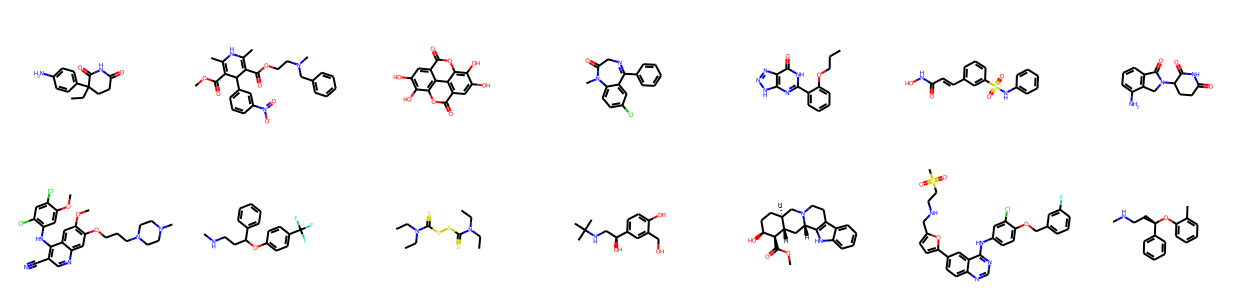

In [19]:
mols = [Chem.MolFromSmiles(s) for s in smiles_list[:14]]
Draw.MolsToGridImage(mols, molsPerRow=7, subImgSize=(180, 150))